<a href="https://colab.research.google.com/github/oliviafelica/pulu-pulu/blob/main/3A_PNBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data lag -> scaling-> lasso -> data diff -> train test split


In [ ]:
import pandas as pd
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
data

,Yield,Luasan,RUT,RUT_Category,WA,CH,HH
Date,,,,,,,
2010-01-01,0.943689,3210.58,9.471057,remaja,200.0,440.85,20.0
2010-02-01,1.075578,3210.58,9.471057,remaja,200.0,259.30,17.0
2010-03-01,1.207757,3210.58,9.471057,remaja,200.0,394.80,22.0
2010-04-01,1.236923,3210.58,9.471057,remaja,200.0,294.40,17.0
2010-05-01,1.194323,3210.58,9.471057,remaja,200.0,271.90,17.0
...,...,...,...,...,...,...,...
2022-08-01,2.356274,2121.37,21.514597,tua,200.0,473.68,17.0
2022-09-01,2.016932,2121.37,21.514597,tua,200.0,439.84,22.0
2022-10-01,1.926632,2121.37,21.514597,tua,200.0,284.70,25.0


In [ ]:
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Menggunakan LabelEncoder pada kolom 'RUT_Category'
data['RUT_Category'] = label_encoder.fit_transform(data['RUT_Category'])

In [ ]:
data

,Yield,Luasan,RUT,RUT_Category,WA,CH,HH
Date,,,,,,,
2010-01-01,0.943689,3210.58,9.471057,1,200.0,440.85,20.0
2010-02-01,1.075578,3210.58,9.471057,1,200.0,259.30,17.0
2010-03-01,1.207757,3210.58,9.471057,1,200.0,394.80,22.0
2010-04-01,1.236923,3210.58,9.471057,1,200.0,294.40,17.0
2010-05-01,1.194323,3210.58,9.471057,1,200.0,271.90,17.0
...,...,...,...,...,...,...,...
2022-08-01,2.356274,2121.37,21.514597,2,200.0,473.68,17.0
2022-09-01,2.016932,2121.37,21.514597,2,200.0,439.84,22.0
2022-10-01,1.926632,2121.37,21.514597,2,200.0,284.70,25.0


In [ ]:
#data.drop(['remaja', 'dewasa', 'tua'], axis=1, inplace=True)

KeyError: ignored

In [ ]:
# Menambahkan 24 lag pada variabel independen
for i in range(1, 25):
    data[f'WA_lag{i}'] = data['WA'].shift(i)
    data[f'CH_lag{i}'] = data['CH'].shift(i)
    data[f'HH_lag{i}'] = data['HH'].shift(i)
    data[f'Luasan_lag{i}'] = data['Luasan'].shift(i)
    data[f'RUT_Category{i}'] = data['RUT_Category'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data = data.dropna()

<ipython-input-61-dc94809e38ef>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'HH_lag{i}'] = data['HH'].shift(i)
<ipython-input-61-dc94809e38ef>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Luasan_lag{i}'] = data['Luasan'].shift(i)
<ipython-input-61-dc94809e38ef>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data.iloc[:120]
test_data = data.iloc[120:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

from sklearn.preprocessing import StandardScaler
# Inisialisasi scaler
scaler = StandardScaler()

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
from sklearn.linear_model import Lasso

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model SARIMAX Anda
X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [ ]:
significant_features

Index(['RUT_Category', 'HH_lag1', 'CH_lag2', 'WA_lag5', 'WA_lag6', 'WA_lag7',
       'HH_lag7', 'WA_lag8', 'HH_lag8', 'WA_lag9', 'WA_lag10', 'WA_lag12',
       'WA_lag13', 'WA_lag17', 'Luasan_lag17', 'WA_lag18', 'CH_lag18',
       'Luasan_lag18', 'CH_lag19', 'HH_lag19', 'CH_lag20', 'CH_lag23'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

KeyboardInterrupt: ignored

In [ ]:
# Plotting
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
%matplotlib inline
def correlation_check(df: pd.DataFrame) -> None:
    """
    Plots a Pearson Correlation Heatmap.
    ---
    Args:
        df (pd.DataFrame): dataframe to plot

    Returns: None
    """

    # Pretty Name
    df.rename(columns={"ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES": "ACTUAL-ESTIMATED"},
              inplace=True)

    # Figure
    fig, ax = plt.subplots(figsize=(16,12), facecolor='w')
    correlations_df = df.corr(method='pearson', min_periods=1)
    sns.heatmap(correlations_df, cmap="Blues", annot=True, linewidth=.1)

    # Labels
    ax.set_title("Pearson Correlation Heatmap", fontsize=15, pad=10)
    ax.set_facecolor(color='white')

data1 = data[significant_features]
data1['Yield'] = data['Yield']
correlation_check(data1)

--------------------------------------------------------------------------------

# Stacking Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Menggunakan LabelEncoder pada kolom 'RUT_Category'
data['RUT_Category'] = label_encoder.fit_transform(data['RUT_Category'])

In [ ]:
# Menambahkan 24 lag pada variabel independen
for i in range(1, 25):
    data[f'WA_lag{i}'] = data['WA'].shift(i)
    data[f'CH_lag{i}'] = data['CH'].shift(i)
    data[f'HH_lag{i}'] = data['HH'].shift(i)
    data[f'Luasan_lag{i}'] = data['Luasan'].shift(i)
    data[f'RUT_Category{i}'] = data['RUT_Category'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data = data.dropna()

In [ ]:
data

,Yield,Luasan,RUT,RUT_Category,WA,CH,HH,WA_lag1,CH_lag1,HH_lag1,...,WA_lag23,CH_lag23,HH_lag23,Luasan_lag23,RUT_Category23,WA_lag24,CH_lag24,HH_lag24,Luasan_lag24,RUT_Category24
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,2.181967,2175.606176,13.471057,0,200.0,202.20,13.0,200.0,313.07,20.0,...,200.0,375.90,18.0,3726.03,0.0,200.0,162.90,12.0,3726.03,0.0
2014-02-01,2.015369,2175.606176,13.471057,0,200.0,169.30,12.0,200.0,202.20,13.0,...,200.0,223.50,14.0,3726.03,0.0,200.0,375.90,18.0,3726.03,0.0
2014-03-01,2.389063,2175.606176,13.471057,0,200.0,389.30,20.0,200.0,169.30,12.0,...,200.0,464.20,13.0,3726.03,0.0,200.0,223.50,14.0,3726.03,0.0
2014-04-01,2.337137,2175.606176,13.471057,0,200.0,230.40,9.0,200.0,389.30,20.0,...,200.0,177.80,9.0,3726.03,0.0,200.0,464.20,13.0,3726.03,0.0
2014-05-01,2.298137,2175.606176,13.471057,0,200.0,449.30,16.0,200.0,230.40,9.0,...,200.0,162.40,6.0,3726.03,0.0,200.0,177.80,9.0,3726.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,2.356274,2121.370000,21.514597,2,200.0,473.68,17.0,200.0,396.60,14.0,...,200.0,332.40,16.0,2179.44,2.0,200.0,167.80,11.0,2179.44,2.0
2022-09-01,2.016932,2121.370000,21.514597,2,200.0,439.84,22.0,200.0,473.68,17.0,...,200.0,379.90,21.0,2179.44,2.0,200.0,332.40,16.0,2179.44,2.0
2022-10-01,1.926632,2121.370000,21.514597,2,200.0,284.70,25.0,200.0,439.84,22.0,...,200.0,516.75,16.0,2179.44,2.0,200.0,379.90,21.0,2179.44,2.0


In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data.iloc[:120]
test_data = data.iloc[120:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

# Inisialisasi scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
from sklearn.linear_model import Lasso

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model SARIMAX Anda
X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [ ]:
significant_features

Index(['HH_lag1', 'CH_lag2', 'WA_lag5', 'WA_lag6', 'WA_lag7', 'HH_lag7',
       'WA_lag8', 'HH_lag8', 'WA_lag9', 'WA_lag10', 'WA_lag12', 'WA_lag13',
       'WA_lag17', 'Luasan_lag17', 'WA_lag18', 'CH_lag18', 'Luasan_lag18',
       'CH_lag19', 'HH_lag19', 'CH_lag20', 'CH_lag23'],
      dtype='object')

In [ ]:
data

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

Random Forest MAPE: 17.44, MSE: 0.13, MAE: 0.32, RMSE: 0.36


In [ ]:
model_lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi regresi linear
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Menampilkan hasil evaluasi untuk model Linear Regression
print(f"Linear Regression MAPE: {mape_lr:.2f}, MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")

Linear Regression MAPE: 17.17, MSE: 0.11, MAE: 0.30, RMSE: 0.32


In [ ]:
"""
model_gbr = GradientBoostingRegressor(random_state = 0).fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi regresi linear
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Gradient Boosting Regressor MAPE: {mape_gbr:.2f}, MSE: {mse_gbr:.2f}, MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}")
"""

Gradient Boosting Regressor MAPE: 15.34, MSE: 0.10, MAE: 0.28, RMSE: 0.31


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definisi hyperparameter yang akan ditelusuri
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Inisialisasi model GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(random_state=0)

# Mencari konfigurasi terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(model_gbr, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mendapatkan model terbaik dari hasil pencarian
best_model_gbr = grid_search.best_estimator_

# Melakukan prediksi dengan model terbaik
y_pred_gbr = best_model_gbr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi GradientBoostingRegressor yang telah dituning
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

# Menampilkan hasil evaluasi untuk model GradientBoostingRegressor yang telah dituning
print(f"Gradient Boosting Regressor MAPE: {mape_gbr:.2f}, MSE: {mse_gbr:.2f}, MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}")


Gradient Boosting Regressor MAPE: 16.91, MSE: 0.12, MAE: 0.30, RMSE: 0.35


In [ ]:
"""
model_nnr = MLPRegressor(
    hidden_layer_sizes = (30,30,30),
    activation = "logistic",
    random_state = 0
).fit(X_train, y_train)

y_pred_nnr = model_nnr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi NNR
mape_nnr = mean_absolute_percentage_error(y_test, y_pred_nnr)
mse_nnr = mean_squared_error(y_test, y_pred_nnr)
mae_nnr = mean_absolute_error(y_test, y_pred_nnr)
rmse_nnr = np.sqrt(mse_nnr)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"NN Regressor MAPE: {mape_nnr:.2f}, MSE: {mse_nnr:.2f}, MAE: {mae_nnr:.2f}, RMSE: {rmse_nnr:.2f}")
"""

NN Regressor MAPE: 18.65, MSE: 0.14, MAE: 0.33, RMSE: 0.38


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Definisi hyperparameter yang akan ditelusuri
param_grid = {
    'hidden_layer_sizes': [(30, 30, 30), (50, 50), (100,)],
    'activation': ['logistic', 'relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Inisialisasi model MLPRegressor
model_nnr = MLPRegressor(random_state=100)

# Mencari konfigurasi terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(model_nnr, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mendapatkan model terbaik dari hasil pencarian
best_model_nnr = grid_search.best_estimator_

# Melakukan prediksi dengan model terbaik
y_pred_nnr = best_model_nnr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi NNR
mape_nnr = mean_absolute_percentage_error(y_test, y_pred_nnr)
mse_nnr = mean_squared_error(y_test, y_pred_nnr)
mae_nnr = mean_absolute_error(y_test, y_pred_nnr)
rmse_nnr = np.sqrt(mse_nnr)

# Menampilkan hasil evaluasi untuk model MLPRegressor yang telah dituning
print(f"NN Regressor MAPE: {mape_nnr:.2f}, MSE: {mse_nnr:.2f}, MAE: {mae_nnr:.2f}, RMSE: {rmse_nnr:.2f}")


NN Regressor MAPE: 16.62, MSE: 0.10, MAE: 0.29, RMSE: 0.32


In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

In [ ]:
regressors = [model_lr, best_model_gbr, best_model_nnr, best_rf]
# regressors = [model_lr, model_nnr]
svr_rbf = SVR(kernel = 'rbf')

stregr = StackingRegressor(
    regressors = regressors,
    meta_regressor = svr_rbf
).fit(X_train, y_train)

pred_stack = stregr.predict(X_test)

print("STACK MAPE:", round(mean_absolute_percentage_error(y_test, pred_stack), 2))
print("STACK explained variance score:", round(explained_variance_score(y_test, pred_stack),2))
print("STACK mean squared error:", round(mean_squared_error(y_test, pred_stack), 2))


STACK MAPE: 15.19
STACK explained variance score: 0.5
STACK mean squared error: 0.1


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to be tuned
hyperparameters = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

# Create the grid search object
grid_search = GridSearchCV(estimator=svr_rbf, param_grid=hyperparameters, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 0.1, 'gamma': 0.1}


# CCF Plot

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
data

,Yield,Luasan,RUT,RUT_Category,WA,CH,HH
Date,,,,,,,
2010-01-01,0.943689,3210.58,9.471057,remaja,200.0,440.85,20.0
2010-02-01,1.075578,3210.58,9.471057,remaja,200.0,259.30,17.0
2010-03-01,1.207757,3210.58,9.471057,remaja,200.0,394.80,22.0
2010-04-01,1.236923,3210.58,9.471057,remaja,200.0,294.40,17.0
2010-05-01,1.194323,3210.58,9.471057,remaja,200.0,271.90,17.0
...,...,...,...,...,...,...,...
2022-08-01,2.356274,2121.37,21.514597,tua,200.0,473.68,17.0
2022-09-01,2.016932,2121.37,21.514597,tua,200.0,439.84,22.0
2022-10-01,1.926632,2121.37,21.514597,tua,200.0,284.70,25.0


In [ ]:
# Time lagged cross correlation
def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation.
    Shifted data (y) filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    x, y : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return x.corr(y.shift(lag))

In [ ]:
def plot_ccf_manual(target, exog, nlags=24):
    """PLot CCF using manual calculations"""
    lags = []
    ccfs = []
    for i in np.arange(0,nlags+1):
        lags.append(i)
        ccfs.append(crosscorr(target, exog, lag=i))

    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation (Manual): {target.name} & {exog.name}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ccf_manual(target, exog, nlags=24):
    """PLot CCF using manual calculations"""
    lags = []
    ccfs = []
    for i in np.arange(0, nlags + 1):
        lags.append(i)
        ccfs.append(crosscorr(target, exog, lag=i))

    # Mengurutkan variabel berdasarkan nilai korelasi secara menurun
    sorted_ccfs = sorted(enumerate(ccfs), key=lambda x: abs(x[1]), reverse=True)

    # Menampilkan 10 variabel dengan korelasi tertinggi
    top_10_correlations = sorted_ccfs[:10]

    print(f"Top 10 Variabel dengan Korelasi Tertinggi:")
    for i, (lag, correlation) in enumerate(top_10_correlations, start=1):
        print(f"{i}. Lag-{lag}: {exog.name} - {correlation}")

    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation (Manual): {target.name} & {exog.name}")


Top 10 Variabel dengan Korelasi Tertinggi:
1. Lag-12: WA - -0.2952880550940676
2. Lag-13: WA - -0.2889160971114548
3. Lag-18: WA - 0.27193142462191916
4. Lag-6: WA - 0.26637663786226456
5. Lag-17: WA - 0.25206570765377456
6. Lag-7: WA - 0.2515961365868938
7. Lag-5: WA - 0.22599807628820812
8. Lag-8: WA - 0.2128268019938077
9. Lag-19: WA - 0.2016590119139306
10. Lag-9: WA - 0.19839229819601975


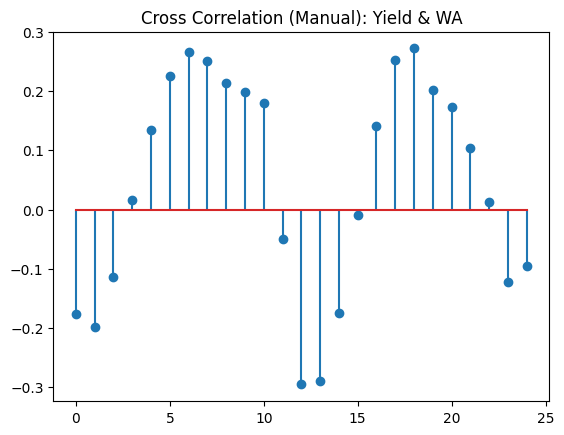

In [ ]:
plot_ccf_manual(data["Yield"], data["WA"])

Top 10 Variabel dengan Korelasi Tertinggi:
1. Lag-14: CH - -0.2920233474919485
2. Lag-19: CH - 0.2646327084234582
3. Lag-13: CH - -0.2594621259788821
4. Lag-20: CH - 0.2371393789193661
5. Lag-3: CH - -0.23512971628556362
6. Lag-2: CH - -0.233800117002819
7. Lag-18: CH - 0.21663275047163938
8. Lag-7: CH - 0.20835725511361844
9. Lag-8: CH - 0.18808727310852713
10. Lag-12: CH - -0.17212337113869525


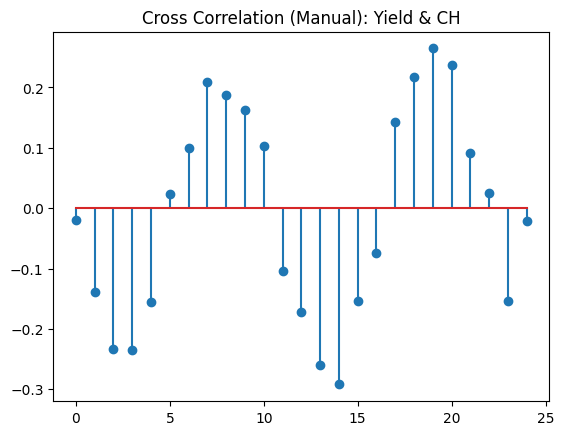

In [ ]:
plot_ccf_manual(data["Yield"], data["CH"])

Top 10 Variabel dengan Korelasi Tertinggi:
1. Lag-7: HH - 0.34456012942878494
2. Lag-8: HH - 0.2930592230275688
3. Lag-13: HH - -0.2777419228605704
4. Lag-1: HH - -0.23428517900236176
5. Lag-14: HH - -0.23104741102366283
6. Lag-6: HH - 0.22579038982437946
7. Lag-2: HH - -0.2166253737521568
8. Lag-19: HH - 0.2143691955906904
9. Lag-20: HH - 0.2005985574659832
10. Lag-9: HH - 0.18086126380637738


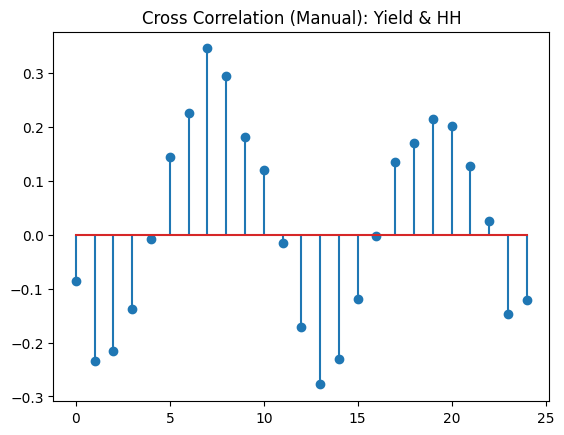

In [ ]:
plot_ccf_manual(data["Yield"], data["HH"])

Top 10 Variabel dengan Korelasi Tertinggi:
1. Lag-0: RUT - 0.1684639988085076
2. Lag-1: RUT - 0.16190714960128028
3. Lag-2: RUT - 0.15924237298140806
4. Lag-3: RUT - 0.1498133097913335
5. Lag-4: RUT - 0.13558210533275097
6. Lag-5: RUT - 0.11583268319784695
7. Lag-6: RUT - 0.10187096654064791
8. Lag-24: RUT - -0.09908114221773556
9. Lag-23: RUT - -0.09040424452824176
10. Lag-11: RUT - 0.08803803951313009


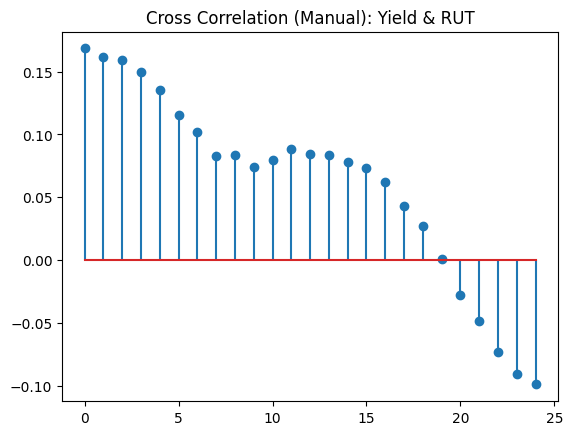

In [ ]:
plot_ccf_manual(data["Yield"], data["RUT"])

## Modelling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
data = data.drop(columns=['RUT_Category'])


In [ ]:
# Menambahkan 24 lag pada variabel independen
for i in range(1, 25):
    data[f'WA_lag{i}'] = data['WA'].shift(i)
    data[f'CH_lag{i}'] = data['CH'].shift(i)
    data[f'HH_lag{i}'] = data['HH'].shift(i)
    data[f'Luasan_lag{i}'] = data['Luasan'].shift(i)
    #data[f'RUT_Category{i}'] = data['RUT_Category'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data = data.dropna()


In [ ]:
# variabel berdasarkan variabel importance rf
significant_features = ['CH_lag7', 'CH_lag13', 'CH_lag19', 'HH_lag1', 'CH_lag3', 'CH_lag18', 'CH_lag2', 'CH_lag20', 'WA_lag7', 'RUT', 'Yield']

# Gunakan fitur signifikan sebagai input untuk model
data = data[significant_features]

In [ ]:
# Melakukan differencing pada semua variabel
data_diff = data.diff(periods=1)  # Misalnya, menggunakan differencing orde 1
data_diff = data_diff.dropna()  # Menghapus baris dengan nilai NaN yang muncul setelah differencing

In [ ]:
data_diff

In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data_diff.iloc[:119]
test_data = data_diff.iloc[119:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

In [ ]:
test_data

,CH_lag7,CH_lag13,CH_lag19,HH_lag1,CH_lag3,CH_lag18,CH_lag2,CH_lag20,WA_lag7,RUT,Yield
Date,,,,,,,,,,,
2022-01-01,83.40,-332.75,80.30,5.0,78.20,-90.30,115.80,-245.10,0.0,0.933778,-0.547672
2022-02-01,-221.80,94.10,-90.30,-13.0,115.80,2.70,-152.90,80.30,-41.1,0.000000,0.272498
2022-03-01,240.29,34.20,2.70,2.0,-152.90,164.60,-99.50,-90.30,41.1,0.000000,0.428289
2022-04-01,-101.59,26.00,164.60,3.0,-99.50,47.50,-11.70,2.70,0.0,0.000000,0.499635
2022-05-01,78.20,-240.51,47.50,-2.0,-11.70,136.85,32.60,164.60,0.0,0.000000,-0.270759
2022-06-01,115.80,149.51,136.85,-3.0,32.60,-332.75,-45.20,47.50,0.0,0.000000,0.279649
2022-07-01,-152.90,83.40,-332.75,5.0,-45.20,94.10,116.10,136.85,0.0,0.000000,-0.053984
2022-08-01,-99.50,-221.80,94.10,-5.0,116.10,34.20,18.40,-332.75,0.0,0.000000,0.000137
2022-09-01,-11.70,240.29,34.20,3.0,18.40,26.00,97.20,94.10,0.0,0.000000,-0.339342


In [ ]:
# Inisialisasi scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)


In [ ]:
y_original

[1.74848126124142,
 1.4505985244335309,
 1.5328657965888115,
 1.6520553966878406,
 1.6283511144316687,
 1.547779332847295,
 1.5793758394929798,
 1.4495477838591588,
 1.3287961721459216,
 1.2330635302717419,
 1.247460767758366,
 1.1398712996515852,
 1.0136664768667702]

In [ ]:
undiff_y=[]

undiff_y.append(y_original[0]+y_pred_rf[0])

# Loop through the differenced forecasted values and inverse difference
for i in range(1, len(y_pred_rf):
    next_value = y_original[-1]+ pred_diff
    y_original.append(next_value)

In [ ]:
y_original = [1.74848126124142]  # Assuming y_train is your original time series data

# Loop through the differenced forecasted values and inverse difference
for pred_diff in y_pred_rf:
    next_value = y_original[-1]+ pred_diff
    y_original.append(next_value)

In [ ]:
y_pred_rf


array([-0.29788274,  0.08226727,  0.1191896 , -0.02370428, -0.08057178,
        0.03159651, -0.12982806, -0.12075161, -0.09573264,  0.01439724,
       -0.10758947, -0.12620482])

In [ ]:
import numpy as np

# Assume you have the differenced values and the original series
differenced_y = y_pred_rf
original_y = [1.74848126124142]  # Example first value of the original series

# Initialize an empty list to store the undifferenced values
undifferenced_y = []

# Calculate the first undifferenced value
undifferenced_y.append(original_y[0] + differenced_y[0])

# Iterate through the remaining differenced values to undifference the series
for i in range(1, len(differenced_y)):
    undifferenced_value = undifferenced_y[-1] + differenced_y[i]
    undifferenced_y.append(undifferenced_value)

# Now, undifferenced_y contains the original series
print(undifferenced_y)

[1.4505985244335309, 1.5328657965888115, 1.6520553966878406, 1.6283511144316687, 1.547779332847295, 1.5793758394929798, 1.4495477838591588, 1.3287961721459216, 1.2330635302717419, 1.247460767758366, 1.1398712996515852, 1.0136664768667702]


In [ ]:
y_original

[1.74848126124142,
 1.4505985244335309,
 1.5328657965888115,
 1.6520553966878406,
 1.6283511144316687,
 1.547779332847295,
 1.5793758394929798,
 1.4495477838591588,
 1.3287961721459216,
 1.2330635302717419,
 1.247460767758366,
 1.1398712996515852,
 1.0136664768667702]

In [ ]:
y_test

Date
2022-01-01   -0.547672
2022-02-01    0.272498
2022-03-01    0.428289
2022-04-01    0.499635
2022-05-01   -0.270759
2022-06-01    0.279649
2022-07-01   -0.053984
2022-08-01    0.000137
2022-09-01   -0.339342
2022-10-01   -0.090300
2022-11-01    0.225548
2022-12-01   -0.809788
Name: Yield, dtype: float64

In [ ]:
y_pred_rf

array([-0.29788274,  0.08226727,  0.1191896 , -0.02370428, -0.08057178,
        0.03159651, -0.12982806, -0.12075161, -0.09573264,  0.01439724,
       -0.10758947, -0.12620482])

In [ ]:

# Membaca data dari file Excel
data1 = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)
data1 = data1.iloc[144:]
y_test1 = data1['Yield']

In [ ]:
y_test1

Date
2022-01-01    1.200809
2022-02-01    1.473307
2022-03-01    1.901597
2022-04-01    2.401231
2022-05-01    2.130472
2022-06-01    2.410122
2022-07-01    2.356138
2022-08-01    2.356274
2022-09-01    2.016932
2022-10-01    1.926632
2022-11-01    2.152180
2022-12-01    1.342392
Name: Yield, dtype: float64

In [ ]:

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test1, undifferenced_y)
mse_rf = mean_squared_error(y_test1, undifferenced_y)
mae_rf = mean_absolute_error(y_test1, undifferenced_y)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")




Random Forest MAPE: 29.97, MSE: 0.49, MAE: 0.62, RMSE: 0.70


In [ ]:

sarima_df = pd.DataFrame({'yield': y_test1, 'y_pred': undifferenced_y})
sarima_df['mape'] = np.abs((y_test1 - undifferenced_y) / y_test1) * 100

# Define a custom style function
def highlight_cells(val):
    if val > 5:
        return 'background-color: #FF5733'  # Red for values greater than 5
    else:
        return 'background-color: #7FFF33'  # Green for other values

# Apply the style function to the DataFrame 'sarima_df'
styled_sarima_df = sarima_df.style.applymap(highlight_cells)

styled_sarima_df


,yield,y_pred,mape
Date,,,
2022-01-01 00:00:00,1.200809,1.450599,20.801779
2022-02-01 00:00:00,1.473307,1.532866,4.042500
2022-03-01 00:00:00,1.901597,1.652055,13.122721
2022-04-01 00:00:00,2.401231,1.628351,32.186827
2022-05-01 00:00:00,2.130472,1.547779,27.350412
2022-06-01 00:00:00,2.410122,1.579376,34.469044
2022-07-01 00:00:00,2.356138,1.449548,38.477801
2022-08-01 00:00:00,2.356274,1.328796,43.606053
2022-09-01 00:00:00,2.016932,1.233064,38.864411


## Modelling 2 diff -> lag

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
data = data.drop(columns=['RUT_Category'])


In [ ]:
# Melakukan differencing pada semua variabel
data_diff = data.diff(periods=1)  # Misalnya, menggunakan differencing orde 1
data_diff = data_diff.dropna()  # Menghapus baris dengan nilai NaN yang muncul setelah differencing

In [ ]:
data_diff

,Yield,Luasan,RUT,WA,CH,HH
Date,,,,,,
2010-02-01,0.131889,0.0,0.0,0.0,-181.55,-3.0
2010-03-01,0.132179,0.0,0.0,0.0,135.50,5.0
2010-04-01,0.029166,0.0,0.0,0.0,-100.40,-5.0
2010-05-01,-0.042600,0.0,0.0,0.0,-22.50,0.0
2010-06-01,0.079948,0.0,0.0,0.0,100.10,-4.0
...,...,...,...,...,...,...
2022-08-01,0.000137,0.0,0.0,0.0,77.08,3.0
2022-09-01,-0.339342,0.0,0.0,0.0,-33.84,5.0
2022-10-01,-0.090300,0.0,0.0,0.0,-155.14,3.0


In [ ]:
# Menambahkan 24 lag pada variabel independen
for i in range(1, 25):
    data_diff[f'WA_lag{i}'] = data_diff['WA'].shift(i)
    data_diff[f'CH_lag{i}'] = data_diff['CH'].shift(i)
    data_diff[f'HH_lag{i}'] = data_diff['HH'].shift(i)
    data_diff[f'Luasan_lag{i}'] = data_diff['Luasan'].shift(i)
    #data[f'RUT_Category{i}'] = data['RUT_Category'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data_diff = data_diff.dropna()


In [ ]:
# variabel berdasarkan variabel importance rf
significant_features = ['CH_lag7', 'CH_lag13', 'CH_lag19', 'HH_lag1', 'CH_lag3', 'CH_lag18', 'CH_lag2', 'CH_lag20', 'WA_lag7', 'RUT', 'Yield']

# Gunakan fitur signifikan sebagai input untuk model
data_diff = data_diff[significant_features]

In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data_diff.iloc[:119]
test_data = data_diff.iloc[119:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

In [ ]:
test_data

,CH_lag7,CH_lag13,CH_lag19,HH_lag1,CH_lag3,CH_lag18,CH_lag2,CH_lag20,WA_lag7,RUT,Yield
Date,,,,,,,,,,,
2022-01-01,83.40,-332.75,80.30,5.0,78.20,-90.30,115.80,-245.10,0.0,0.933778,-0.547672
2022-02-01,-221.80,94.10,-90.30,-13.0,115.80,2.70,-152.90,80.30,-41.1,0.000000,0.272498
2022-03-01,240.29,34.20,2.70,2.0,-152.90,164.60,-99.50,-90.30,41.1,0.000000,0.428289
2022-04-01,-101.59,26.00,164.60,3.0,-99.50,47.50,-11.70,2.70,0.0,0.000000,0.499635
2022-05-01,78.20,-240.51,47.50,-2.0,-11.70,136.85,32.60,164.60,0.0,0.000000,-0.270759
2022-06-01,115.80,149.51,136.85,-3.0,32.60,-332.75,-45.20,47.50,0.0,0.000000,0.279649
2022-07-01,-152.90,83.40,-332.75,5.0,-45.20,94.10,116.10,136.85,0.0,0.000000,-0.053984
2022-08-01,-99.50,-221.80,94.10,-5.0,116.10,34.20,18.40,-332.75,0.0,0.000000,0.000137
2022-09-01,-11.70,240.29,34.20,3.0,18.40,26.00,97.20,94.10,0.0,0.000000,-0.339342


In [ ]:
# Inisialisasi scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)


In [ ]:
y_pred_rf


array([-0.29788274,  0.08226727,  0.1191896 , -0.02370428, -0.08057178,
        0.03159651, -0.12982806, -0.12075161, -0.09573264,  0.01439724,
       -0.10758947, -0.12620482])

In [ ]:
import numpy as np

# Assume you have the differenced values and the original series
differenced_y = y_pred_rf
original_y = [1.74848126124142]  # Example first value of the original series

# Initialize an empty list to store the undifferenced values
undifferenced_y = []

# Calculate the first undifferenced value
undifferenced_y.append(original_y[0] + differenced_y[0])

# Iterate through the remaining differenced values to undifference the series
for i in range(1, len(differenced_y)):
    undifferenced_value = undifferenced_y[-1] + differenced_y[i]
    undifferenced_y.append(undifferenced_value)

# Now, undifferenced_y contains the original series
print(undifferenced_y)

[1.4505985244335309, 1.5328657965888115, 1.6520553966878406, 1.6283511144316687, 1.547779332847295, 1.5793758394929798, 1.4495477838591588, 1.3287961721459216, 1.2330635302717419, 1.247460767758366, 1.1398712996515852, 1.0136664768667702]


In [ ]:
y_original

[1.74848126124142,
 1.4505985244335309,
 1.5328657965888115,
 1.6520553966878406,
 1.6283511144316687,
 1.547779332847295,
 1.5793758394929798,
 1.4495477838591588,
 1.3287961721459216,
 1.2330635302717419,
 1.247460767758366,
 1.1398712996515852,
 1.0136664768667702]

In [ ]:

# Membaca data dari file Excel
data1 = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)
data1 = data1.iloc[144:]
y_test1 = data1['Yield']

In [ ]:
y_test1

Date
2022-01-01    1.200809
2022-02-01    1.473307
2022-03-01    1.901597
2022-04-01    2.401231
2022-05-01    2.130472
2022-06-01    2.410122
2022-07-01    2.356138
2022-08-01    2.356274
2022-09-01    2.016932
2022-10-01    1.926632
2022-11-01    2.152180
2022-12-01    1.342392
Name: Yield, dtype: float64

In [ ]:

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test1, undifferenced_y)
mse_rf = mean_squared_error(y_test1, undifferenced_y)
mae_rf = mean_absolute_error(y_test1, undifferenced_y)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")




Random Forest MAPE: 29.97, MSE: 0.49, MAE: 0.62, RMSE: 0.70


In [ ]:

sarima_df = pd.DataFrame({'yield': y_test1, 'y_pred': undifferenced_y})
sarima_df['mape'] = np.abs((y_test1 - undifferenced_y) / y_test1) * 100

# Define a custom style function
def highlight_cells(val):
    if val > 5:
        return 'background-color: #FF5733'  # Red for values greater than 5
    else:
        return 'background-color: #7FFF33'  # Green for other values

# Apply the style function to the DataFrame 'sarima_df'
styled_sarima_df = sarima_df.style.applymap(highlight_cells)

styled_sarima_df


,yield,y_pred,mape
Date,,,
2022-01-01 00:00:00,1.200809,1.450599,20.801779
2022-02-01 00:00:00,1.473307,1.532866,4.042500
2022-03-01 00:00:00,1.901597,1.652055,13.122721
2022-04-01 00:00:00,2.401231,1.628351,32.186827
2022-05-01 00:00:00,2.130472,1.547779,27.350412
2022-06-01 00:00:00,2.410122,1.579376,34.469044
2022-07-01 00:00:00,2.356138,1.449548,38.477801
2022-08-01 00:00:00,2.356274,1.328796,43.606053
2022-09-01 00:00:00,2.016932,1.233064,38.864411


------------------------------------------------------------------------------

In [ ]:
from sklearn.linear_model import Lasso

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model
X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [ ]:
data_diff

,Yield,Luasan,RUT,WA,CH,HH,WA_lag1,CH_lag1,HH_lag1,Luasan_lag1,...,HH_lag22,Luasan_lag22,WA_lag23,CH_lag23,HH_lag23,Luasan_lag23,WA_lag24,CH_lag24,HH_lag24,Luasan_lag24
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-01,0.034152,0.0,0.0,0.0,213.00,6.0,0.0,-240.85,-5.0,44.39,...,-5.0,0.0,0.0,135.50,5.0,0.0,0.0,-181.55,-3.0,0.0
2012-03-01,0.188533,0.0,0.0,0.0,-152.40,-4.0,0.0,213.00,6.0,0.00,...,0.0,0.0,0.0,-100.40,-5.0,0.0,0.0,135.50,5.0,0.0
2012-04-01,-0.004836,0.0,0.0,0.0,240.70,-1.0,0.0,-152.40,-4.0,0.00,...,-4.0,0.0,0.0,-22.50,0.0,0.0,0.0,-100.40,-5.0,0.0
2012-05-01,0.384718,0.0,0.0,0.0,-286.40,-4.0,0.0,240.70,-1.0,0.00,...,2.0,0.0,0.0,100.10,-4.0,0.0,0.0,-22.50,0.0,0.0
2012-06-01,-0.153815,0.0,0.0,0.0,-15.40,-3.0,0.0,-286.40,-4.0,0.00,...,-1.0,0.0,0.0,35.70,2.0,0.0,0.0,100.10,-4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.000137,0.0,0.0,0.0,77.08,3.0,0.0,97.20,-5.0,0.00,...,5.0,0.0,0.0,164.60,5.0,0.0,0.0,2.70,-13.0,0.0
2022-09-01,-0.339342,0.0,0.0,0.0,-33.84,5.0,0.0,77.08,3.0,0.00,...,-5.0,0.0,0.0,47.50,5.0,0.0,0.0,164.60,5.0,0.0
2022-10-01,-0.090300,0.0,0.0,0.0,-155.14,3.0,0.0,-33.84,5.0,0.00,...,3.0,0.0,0.0,136.85,-5.0,0.0,0.0,47.50,5.0,0.0


In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data_diff.iloc[:120]
test_data = data_diff.iloc[120:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

# Inisialisasi scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
significant_features

Index(['HH_lag1', 'CH_lag2', 'WA_lag5', 'WA_lag6', 'WA_lag7', 'HH_lag7',
       'WA_lag8', 'HH_lag8', 'WA_lag9', 'WA_lag10', 'WA_lag12', 'WA_lag13',
       'WA_lag17', 'Luasan_lag17', 'WA_lag18', 'CH_lag18', 'Luasan_lag18',
       'CH_lag19', 'HH_lag19', 'CH_lag20', 'CH_lag23'],
      dtype='object')

In [ ]:
X_train

In [ ]:
from sklearn.linear_model import Lasso

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model SARIMAX Anda
X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [ ]:
# # variabel berdasarkan variabel importance rf
# significant_features = ['CH_lag7', 'CH_lag13', 'CH_lag19', 'HH_lag1', 'CH_lag3', 'CH_lag18', 'CH_lag2', 'CH_lag20', 'WA_lag7', 'RUT']

# # Gunakan fitur signifikan sebagai input untuk model
# X_train = X_train[significant_features]
# X_test = X_test[significant_features]

In [ ]:
X_train

,CH_lag7,CH_lag13,CH_lag19,HH_lag1,CH_lag3,CH_lag18,CH_lag2,CH_lag20,WA_lag7,RUT
Date,,,,,,,,,,
2012-01-01,-1.172637,-0.174351,0.880760,0.571318,2.201326,1.169256,1.133301,0.097598,-0.327998,-1.561100
2012-02-01,-0.692774,0.200399,1.157897,-0.392660,1.097500,-0.001332,1.177205,0.876009,-0.112101,-1.561100
2012-03-01,-1.671849,-0.562510,-0.008871,0.764113,1.140557,1.249476,-0.745412,1.153624,-1.812763,-1.561100
2012-04-01,-0.290309,0.313287,1.237855,-0.007069,-0.744949,1.261158,0.954889,-0.015159,-0.809032,-1.561100
2012-05-01,2.209622,0.155292,1.249499,-0.199865,0.922532,1.469983,-0.261665,1.233720,0.395446,-1.561100
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0.188393,-0.696318,-0.945079,-1.356638,-0.084220,0.864732,0.594074,0.516742,0.395446,1.591488
2021-09-01,0.453092,-0.675252,0.854366,0.764113,0.568682,-0.037158,-1.176475,-0.952985,0.395446,1.591488
2021-10-01,0.654325,0.608990,-0.044580,0.956909,-1.167691,1.266610,0.741673,0.849570,0.395446,1.591488


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Membagi data menjadi data pelatihan dan pengujian
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Differencing pada semua variabel pada data pelatihan
train_data_diff = train_data.diff(periods=1).dropna()

# Differencing pada semua variabel pada data pengujian
test_data_diff = test_data.diff(periods=1).dropna()

# Menambahkan 24 lag pada variabel independen di data pelatihan
lags = 24
for lag in range(1, lags + 1):
    for col in ['WA', 'CH', 'HH', 'Luasan']:
        train_data_diff[f'{col}_lag{lag}'] = train_data_diff[col].shift(lag)
        test_data_diff[f'{col}_lag{lag}'] = test_data_diff[col].shift(lag)

# Menghapus baris dengan nilai NaN setelah penambahan lag variables
train_data_diff = train_data_diff.dropna()
test_data_diff = test_data_diff.dropna()

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data_diff['Yield']
X_train = train_data_diff.drop(columns=['Yield'])

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data_diff['Yield']
X_test = test_data_diff.drop(columns=['Yield'])

# Inisialisasi scaler dan melakukan scaling pada data pelatihan
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scaling data pengujian dengan scaler yang sama
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model
X_train = X_train[significant_features]
X_test = X_test[significant_features]

# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")


In [ ]:
y_test

Date
2022-02-01    0.272498
2022-03-01    0.428289
2022-04-01    0.499635
2022-05-01   -0.270759
2022-06-01    0.279649
2022-07-01   -0.053984
2022-08-01    0.000137
2022-09-01   -0.339342
2022-10-01   -0.090300
2022-11-01    0.225548
2022-12-01   -0.809788
Name: Yield, dtype: float64

In [ ]:
y_pred_rf

array([ 0.0976895 , -0.12608664,  0.11604471, -0.22722274,  0.14333649,
        0.03895604, -0.17517215, -0.0672646 , -0.13889458,  0.1009273 ,
       -0.22754382])

In [ ]:
# Mendapatkan tingkat signifikansi dari setiap fitur
feature_importance = best_rf.feature_importances_

# Membuat DataFrame yang berisi nama fitur dan tingkat signifikansi
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Mengurutkan fitur berdasarkan tingkat signifikansi
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Menampilkan 10 fitur teratas yang paling signifikan
top_10_significant_features = sorted_feature_importance.head(10)
print("Top 10 Fitur Signifikan:")
print(top_10_significant_features)


Top 10 Fitur Signifikan:
     Feature  Importance
16   CH_lag7    0.076647
11  CH_lag13    0.058284
10  CH_lag19    0.054793
20   HH_lag1    0.051998
13   CH_lag3    0.050594
15  CH_lag18    0.050231
14   CH_lag2    0.044242
12  CH_lag20    0.043633
5    WA_lag7    0.043358
26       RUT    0.041803


In [ ]:
import pandas as pd
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
import itertools
# Menentukan rentang nilai untuk p, d, q, P, D, Q, dan s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = float('inf')
best_param = None
best_seasonal_param = None
warnings.filterwarnings("ignore")

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, exog=X_train, order=param, seasonal_order=seasonal_param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            continue

print(f"Best ARIMA parameters: {best_param}, Best Seasonal parameters: {best_seasonal_param}, AIC: {best_aic}")

Best ARIMA parameters: (1, 1, 1), Best Seasonal parameters: (0, 0, 1, 12), AIC: 39.398259405969455


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Menyesuaikan model SARIMAX
sarimax_model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 1, 12))
sarimax_results = sarimax_model.fit()

# Membuat prediksi menggunakan model SARIMAX
y_pred_sarimax = sarimax_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test)

# Menghitung metrik evaluasi untuk prediksi SARIMAX
mape_sarimax = mean_absolute_percentage_error(y_test, y_pred_sarimax)
mse_sarimax = mean_squared_error(y_test, y_pred_sarimax)
mae_sarimax = mean_absolute_error(y_test, y_pred_sarimax)
rmse_sarimax = np.sqrt(mse_sarimax)

# Menampilkan hasil evaluasi untuk model SARIMAX
print(f"SARIMAX MAPE: {mape_sarimax:.2f}, MSE: {mse_sarimax:.2f}, MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}")

SARIMAX MAPE: 17.93, MSE: 0.17, MAE: 0.36, RMSE: 0.41


--------------------------------------------------------------------------------

## Tanpa RUT

In [ ]:
import pandas as pd
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Membaca data dari file Excel
data = pd.read_excel('/content/Data 1.xlsx', sheet_name=1, parse_dates=['Periode Waktu'])
data['Periode Waktu'] = pd.to_datetime(data['Periode Waktu'])
data.set_index('Periode Waktu', inplace=True)

# Menetapkan frekuensi bulanan pada indeks
data.index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='M')


In [ ]:
# Menambahkan 24 lag pada variabel independen
for i in range(1, 25):
    data[f'WA_lag{i}'] = data['WA'].shift(i)
    data[f'CurahHujan_lag{i}'] = data['Curah Hujan'].shift(i)
    data[f'HariHujan_lag{i}'] = data['Hari Hujan'].shift(i)
    data[f'Yield_lag{i}'] = data['Yield'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data = data.dropna()

-------------------------------------------------------------------------------

# STACKING dengan Lag Yield

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
# Membaca data dari file Excel
data = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data = data.drop(columns=['RUT_Category'])

from sklearn.preprocessing import LabelEncoder
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Menggunakan LabelEncoder pada kolom 'RUT_Category'
#data['RUT_Category'] = label_encoder.fit_transform(data['RUT_Category'])

# Menambahkan 24 lag pada variabel independen
for i in range(1, 20):
    data[f'WA_lag{i}'] = data['WA'].shift(i)
    data[f'CH_lag{i}'] = data['CH'].shift(i)
    data[f'HH_lag{i}'] = data['HH'].shift(i)
    data[f'Luasan_lag{i}'] = data['Luasan'].shift(i)
    data[f'Yield{i}'] = data['Yield'].shift(i)

# Menghapus baris dengan nilai NaN setelah membuat variabel lag
data = data.dropna()


In [ ]:
X_train

,Luasan,WA,HH_lag1,Yield1,WA_lag2,HH_lag2,Yield2,CH_lag4,WA_lag5,CH_lag5,...,HH_lag15,Yield15,HH_lag16,Luasan_lag16,Luasan_lag17,CH_lag18,Luasan_lag18,CH_lag19,HH_lag19,Yield19
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,2.401473,-1.817191,-1.431882,-1.483719,-0.327998,-1.726825,-1.319365,0.146944,0.392394,0.307886,...,0.732971,-1.678928,0.735587,1.026821,1.010412,0.005676,0.994283,1.397994,1.292730,-2.173904
2011-09-01,2.401473,-0.813813,-2.290868,-1.561970,-0.112101,-1.396453,-1.467352,0.076863,0.392394,0.149990,...,-0.046095,-1.473105,0.735587,1.026821,1.010412,1.064274,0.994283,-0.014057,0.715045,-1.850638
2011-10-01,2.401473,0.390239,-0.763782,-0.905397,-1.812763,-2.245982,-1.545107,-1.192379,0.392394,0.079814,...,0.343438,-1.294770,-0.044532,1.026821,1.010412,0.279896,0.994283,1.039829,1.677853,-1.526662
2011-11-01,2.401473,0.390239,0.238369,-0.798504,-0.809032,-0.735708,-0.892690,-0.709600,-0.330593,-1.191152,...,0.148672,0.555191,0.345528,1.026821,1.010412,0.104114,0.994283,0.258942,0.715045,-1.455174
2011-12-01,2.401473,0.390239,0.238369,-0.899969,0.395446,0.255409,-0.786473,-1.694626,-0.114833,-0.707717,...,-0.825161,-0.155936,0.150498,1.026821,1.010412,0.886149,0.994283,0.083943,0.715045,-1.559588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,-0.408948,0.390239,0.811026,-0.180151,0.395446,1.388115,-0.509811,2.035234,0.392394,0.973778,...,1.609421,-0.168651,-0.239562,-0.594397,-0.606351,-1.689254,-0.618358,-1.665273,-1.691975,0.947175
2021-04-01,-0.408948,0.053862,0.429254,0.246153,0.395446,0.821762,-0.172034,-0.555811,0.392394,2.040843,...,0.538205,-0.850976,1.613222,-0.594397,-0.606351,-0.560343,-0.618358,-1.701440,-1.884536,-0.222666
2021-05-01,-0.408948,0.390239,-0.525174,0.159490,0.395446,0.444194,0.251572,0.176923,0.392394,-0.553720,...,1.122504,-0.499390,0.540558,-0.608160,-0.606351,-0.186513,-0.618358,-0.577555,-0.247763,0.236062


In [ ]:
# Membagi data menjadi data pelatihan dan pengujian
train_data = data.iloc[:120]
test_data = data.iloc[120:]

# Menentukan variabel dependen dan independen untuk pelatihan
y_train = train_data['Yield']
X_train = train_data.drop(columns=['Yield'])

# Inisialisasi scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Menentukan variabel dependen dan independen untuk pengujian
y_test = test_data['Yield']
X_test = test_data.drop(columns=['Yield'])

# Melakukan scaling pada data pelatihan dan pengujian
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengonversi kembali ke DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
from sklearn.linear_model import Lasso

# Menyesuaikan model LASSO
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Dapatkan fitur yang signifikan
significant_features = X_train.columns[lasso.coef_ != 0]

# Gunakan fitur signifikan sebagai input untuk model SARIMAX Anda
X_train = X_train[significant_features]
X_test = X_test[significant_features]


In [ ]:
significant_features

Index(['Yield1', 'WA_lag12'], dtype='object')

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=100)

# Rentang nilai untuk setiap parameter dalam Random Forest
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV untuk menemukan parameter terbaik dalam Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Model terbaik dari hasil GridSearchCV
best_rf = grid_search.best_estimator_

# Membuat prediksi menggunakan model Random Forest
y_pred_rf = best_rf.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi Random Forest
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Menampilkan hasil evaluasi untuk model Random Forest
print(f"Random Forest MAPE: {mape_rf:.2f}, MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")


Random Forest MAPE: 16.71, MSE: 0.13, MAE: 0.30, RMSE: 0.35


In [ ]:

model_lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi regresi linear
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Menampilkan hasil evaluasi untuk model Linear Regression
print(f"Linear Regression MAPE: {mape_lr:.2f}, MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definisi hyperparameter yang akan ditelusuri
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Inisialisasi model GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(random_state=0)

# Mencari konfigurasi terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(model_gbr, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mendapatkan model terbaik dari hasil pencarian
best_model_gbr = grid_search.best_estimator_

# Melakukan prediksi dengan model terbaik
y_pred_gbr = best_model_gbr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi GradientBoostingRegressor yang telah dituning
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

# Menampilkan hasil evaluasi untuk model GradientBoostingRegressor yang telah dituning
print(f"Gradient Boosting Regressor MAPE: {mape_gbr:.2f}, MSE: {mse_gbr:.2f}, MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}")


from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Definisi hyperparameter yang akan ditelusuri
param_grid = {
    'hidden_layer_sizes': [(30, 30, 30), (50, 50), (100,)],
    'activation': ['logistic', 'relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Inisialisasi model MLPRegressor
model_nnr = MLPRegressor(random_state=100)

# Mencari konfigurasi terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(model_nnr, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mendapatkan model terbaik dari hasil pencarian
best_model_nnr = grid_search.best_estimator_

# Melakukan prediksi dengan model terbaik
y_pred_nnr = best_model_nnr.predict(X_test)

# Menghitung metrik evaluasi untuk prediksi NNR
mape_nnr = mean_absolute_percentage_error(y_test, y_pred_nnr)
mse_nnr = mean_squared_error(y_test, y_pred_nnr)
mae_nnr = mean_absolute_error(y_test, y_pred_nnr)
rmse_nnr = np.sqrt(mse_nnr)

# Menampilkan hasil evaluasi untuk model MLPRegressor yang telah dituning
print(f"NN Regressor MAPE: {mape_nnr:.2f}, MSE: {mse_nnr:.2f}, MAE: {mae_nnr:.2f}, RMSE: {rmse_nnr:.2f}")


from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR


regressors = [model_lr, best_model_gbr, best_model_nnr, best_rf]
# regressors = [model_lr, model_nnr]
svr_rbf = SVR(kernel = 'rbf')

stregr = StackingRegressor(
    regressors = regressors,
    meta_regressor = svr_rbf
).fit(X_train, y_train)

pred_stack = stregr.predict(X_test)

print("STACK MAPE:", round(mean_absolute_percentage_error(y_test, pred_stack), 2))
print("STACK explained variance score:", round(explained_variance_score(y_test, pred_stack),2))
print("STACK mean squared error:", round(mean_squared_error(y_test, pred_stack), 2))

---------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
data = pd.read_excel('/content/Data 3.xlsx', index_col='Date', parse_dates=True)

# Determine the order of differencing (d) needed to make the time series stationary
d = sm.tsa.adfuller(data['CH'])[1] < 0.05  # Menggunakan sm.tsa.adfuller daripada sm.tsa.stattools.adfuller

# Determine the order of the seasonal differencing (D) needed to make the seasonal time series stationary
D = sm.tsa.adfuller(data['CH'], maxlag=12)[1] < 0.05  # Menggunakan sm.tsa.adfuller daripada sm.tsa.stattools.adfuller

# Determine the orders of the autoregressive (p) and moving average (q) terms using the ACF and PACF plots
p, q = sm.tsa.arma_order_select_ic(data['CH'], max_ar=3, max_ma=3, ic='aic')['aic_min_order']

# Fit the SARIMA model with the determined orders
model = sm.tsa.SARIMAX(data['CH'], order=(p, d, q), seasonal_order=(0, D, 0, 12))
results = model.fit()

# Use the fitted model to make predictions
forecast = results.get_forecast(steps=12)  # Menggunakan 12 langkah ke depan untuk membuat prediksi

# Ambil prediksi dan interval prediksi (opsional)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Sekarang Anda dapat menggunakan prediksi dan interval prediksi (jika diperlukan) untuk analisis atau evaluasi lebih lanjut
print(forecast_mean)
print(forecast_ci)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No 

2023-01-01    195.481436
2023-02-01    151.341739
2023-03-01    174.146580
2023-04-01    116.491275
2023-05-01    253.014658
2023-06-01    266.343786
2023-07-01    365.291483
2023-08-01    435.871810
2023-09-01    406.954081
2023-10-01    250.124612
2023-11-01    313.028835
2023-12-01    180.981768
Freq: MS, Name: predicted_mean, dtype: float64
              lower CH    upper CH
2023-01-01 -112.196152  503.159025
2023-02-01 -184.028473  486.711951
2023-03-01 -194.269164  542.562323
2023-04-01 -261.383232  494.365783
2023-05-01 -163.865199  669.894516
2023-06-01 -171.941065  704.628637
2023-07-01 -100.414317  830.997283
2023-08-01  -46.240994  917.984614
2023-09-01  -98.291941  912.200103
2023-10-01 -273.428630  773.677854
2023-11-01 -231.369774  857.427444
2023-12-01 -380.438139  742.401675


In [ ]:
import plotly.express as px
import pandas as pd

# Load data and preprocess as you did
data1 = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)
data1 = data1['CH']
# Create a new DataFrame for train and test data
train_data = data1.iloc[:144]
test_data = data1.iloc[144:156]




In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Menentukan rentang nilai untuk p, d, q, P, D, Q, dan s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = float('inf')
best_param = None
best_seasonal_param = None
warnings.filterwarnings("ignore")

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(y_train, exog=X_train, order=param, seasonal_order=seasonal_param)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            continue

print(f"Best SARIMA parameters: {best_param}, Best Seasonal parameters: {best_seasonal_param}, AIC: {best_aic}")

# Menyesuaikan model SARIMA dengan parameter terbaik yang ditemukan
sarima_model = SARIMAX(train_data, order=best_param, seasonal_order=best_seasonal_param)
sarima_results = sarima_model.fit()

# Membuat prediksi menggunakan model SARIMA
y_pred_sarima = sarima_results.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test)
y_pred_sarima_mean = y_pred_sarima.predicted_mean

# Menghitung metrik evaluasi untuk prediksi SARIMA
mape_sarima = mean_absolute_percentage_error(y_test, y_pred_sarima_mean)
mse_sarima = mean_squared_error(y_test, y_pred_sarima_mean)
mae_sarima = mean_absolute_error(y_test, y_pred_sarima_mean)
rmse_sarima = np.sqrt(mse_sarima)

# Menampilkan hasil evaluasi untuk model SARIMA
print(f"SARIMA MAPE: {mape_sarima:.2f}, MSE: {mse_sarima:.2f}, MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")



Best SARIMA parameters: None, Best Seasonal parameters: None, AIC: inf


NameError: ignored

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Fungsi untuk menghitung mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load data and preprocess as you did
data1 = pd.read_excel('/content/Data 3.xlsx', parse_dates=['Date'])
data1.set_index('Date', inplace=True)
y = data1['CH']

# Split data into train and test
train_size = 144
y_train = y[:train_size]
y_test = y[train_size:156]

# Menentukan rentang nilai untuk p, d, q, P, D, Q, dan s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_aic = float('inf')
best_param = None
best_seasonal_param = None
warnings.filterwarnings("ignore")

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, exog=None, order=param, seasonal_order=seasonal_param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            continue

print(f"Best SARIMA parameters: {best_param}, Best Seasonal parameters: {best_seasonal_param}, AIC: {best_aic}")

# Menyesuaikan model SARIMA dengan parameter terbaik
sarima_model = SARIMAX(y_train, exog=None, order=best_param, seasonal_order=best_seasonal_param)
sarima_results = sarima_model.fit()

# Membuat prediksi menggunakan model SARIMA
y_pred_sarima = sarima_results.get_forecast(steps=len(y_test))

# Menghitung metrik evaluasi untuk prediksi SARIMA
mape_sarima = mean_absolute_percentage_error(y_test, y_pred_sarima.predicted_mean)
mse_sarima = mean_squared_error(y_test, y_pred_sarima.predicted_mean)
mae_sarima = mean_absolute_error(y_test, y_pred_sarima.predicted_mean)
rmse_sarima = np.sqrt(mse_sarima)

# Menampilkan hasil evaluasi untuk model SARIMA
print(f"SARIMA MAPE: {mape_sarima:.2f}, MSE: {mse_sarima:.2f}, MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

sarima_df = pd.DataFrame({'yield': y_test, 'y_pred': y_pred_sarima.predicted_mean})
sarima_df['mape'] = np.abs((y_test - y_pred_sarima.predicted_mean) / y_test) * 100

# Define a custom style function
def highlight_cells(val):
    if val > 5:
        return 'background-color: #FF5733'  # Red for values greater than 5
    else:
        return 'background-color: #7FFF33'  # Green for other values

# Apply the style function to the DataFrame 'sarima_df'
styled_sarima_df = sarima_df.style.applymap(highlight_cells)

styled_sarima_df


Best SARIMA parameters: (1, 1, 1), Best Seasonal parameters: (0, 1, 1, 7), AIC: 1731.9909073976105
SARIMA MAPE: 29.73, MSE: 12467.07, MAE: 88.66, RMSE: 111.66


,yield,y_pred,mape
2022-01-01 00:00:00,189.200000,256.480704,35.560626
2022-02-01 00:00:00,177.500000,237.067327,33.559058
2022-03-01 00:00:00,210.100000,236.454058,12.543578
2022-04-01 00:00:00,164.900000,273.383144,65.787231
2022-05-01 00:00:00,281.000000,263.057848,6.385107
2022-06-01 00:00:00,299.400000,270.989058,9.489293
2022-07-01 00:00:00,396.600000,246.709317,37.793919
2022-08-01 00:00:00,473.680000,244.290518,48.427099
2022-09-01 00:00:00,439.840000,232.967123,47.033666
2022-10-01 00:00:00,284.700000,234.550052,17.615015


-------------------------------------------------------------------------------------------

In [ ]:
y_test

Date
2022-01-01    189.20
2022-02-01    177.50
2022-03-01    210.10
2022-04-01    164.90
2022-05-01    281.00
2022-06-01    299.40
2022-07-01    396.60
2022-08-01    473.68
2022-09-01    439.84
2022-10-01    284.70
2022-11-01    345.75
2022-12-01    215.96
Name: CH, dtype: float64